We will use a artificial recurrent nueral network called a LSTM (Long Short Term Memory) to predict Housing prices. I will pull data from the sql databases that I created *test changes*


In [456]:
import torch
print(torch.cuda.is_available())
print(torch.version.hip)  # should show ROCm backend


True
6.4.43483-a187df25c


In [457]:
#import Libraries
import math 
import pandas_datareader as web
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.style.use('fivethirtyeight')
import datetime
import pandas as pd
import sqlalchemy as sa
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


In [458]:
import sqlalchemy as sa
import pandas as pd
import urllib

params = urllib.parse.quote_plus(
    "DRIVER={ODBC Driver 18 for SQL Server};"
    "SERVER=localhost;"
    "DATABASE=Housing;"
    "UID=SA;"
    "PWD=SuperK_0606$;"
    "Encrypt=no;"
    "TrustServerCertificate=yes"
)

connection_string_Housing = f"mssql+pyodbc:///?odbc_connect={params}"

engine = sa.create_engine(connection_string_Housing)

# Read table into DataFrame
Housing_prices_df = pd.read_sql('SELECT * FROM hpi_avg_monthly', engine)
print(Housing_prices_df.head())






      column1     avg_hpi
0  1991-01-01  100.000000
1  1991-02-01  100.355000
2  1991-03-01  100.568999
3  1991-04-01  100.460500
4  1991-05-01  100.490500


/home/kalle/kdatascience/lib/python3.12/site-packages/pandas/io/sql.py:1648: SAWarning: Unrecognized server version info '17.0.800.3'.  Some SQL Server features may not function properly.
  con = self.exit_stack.enter_context(con.connect())


In [459]:
#Get number of rows and columns
print(Housing_prices_df.shape)
print (Housing_prices_df['avg_hpi'].max())

(411, 2)
445.5010025024414


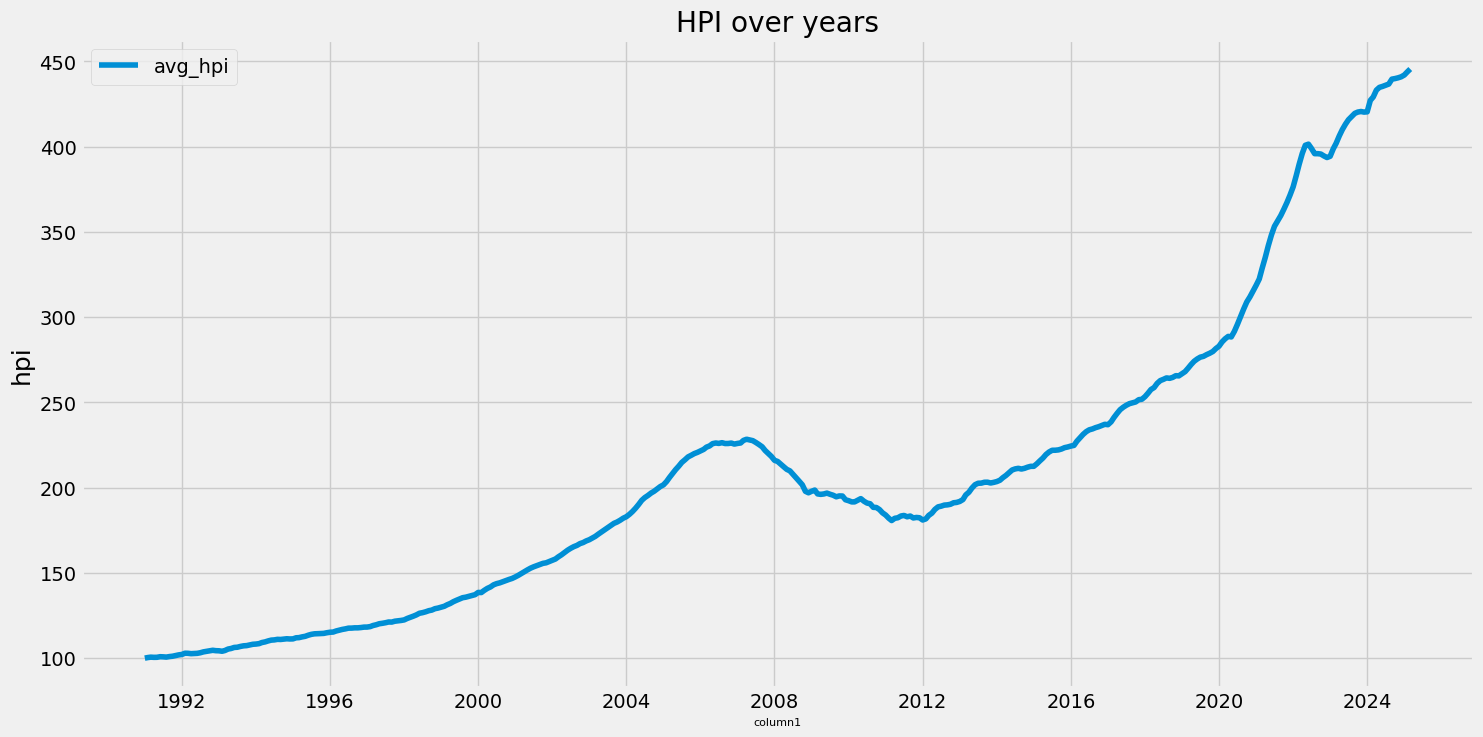

In [460]:
#Visualize the data 
#Housing_prices_df['Year'] = pd.to_datetime(Housing_prices_df['Year'])
Housing_prices_df.set_index('column1',inplace=True)
Housing_prices_df.sort_index(inplace=True)
plt.figure(figsize=(16,8))
plt.title('HPI over years')
#plt.plot(Housing_prices_df['Year'],Housing_prices_df['avg_hpi'])
plt.xlabel('Date', fontsize=8)
plt.ylabel('hpi', fontsize=18)
Housing_prices_df.plot(ax=plt.gca())
plt.show()

In [461]:
#create a new dataframe with only the "Close" column
close_stock = Housing_prices_df#.filter(['avg_hpi_year'])
#Convert the data frame to a numpy array
dataset = close_stock.to_numpy()
dataset.shape
#get the number of rows to train the model on 
Training_data_len = math.ceil(len(dataset)*.9)
Training_data_len


370

In [462]:
#Good practice to Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
#create variable to hold scaled data
print(dataset.shape)
scaled_data = scaler.fit_transform(dataset)#<----computes minimum and maximum values that are used for scaling and transforms data based on those values

scaled_data

(411, 1)


array([[0.        ],
       [0.00102749],
       [0.00164688],
       [0.00133285],
       [0.00141968],
       [0.00238928],
       [0.00217366],
       [0.00175253],
       [0.0026353 ],
       [0.00321562],
       [0.0043285 ],
       [0.00549637],
       [0.00621417],
       [0.00832704],
       [0.00821126],
       [0.00756582],
       [0.00776843],
       [0.00814035],
       [0.00910707],
       [0.01062515],
       [0.01158463],
       [0.01252529],
       [0.01330966],
       [0.01263817],
       [0.01245004],
       [0.01168882],
       [0.01295221],
       [0.01538635],
       [0.0163878 ],
       [0.01815046],
       [0.01847607],
       [0.01986825],
       [0.02088561],
       [0.02124161],
       [0.02249053],
       [0.02351079],
       [0.02388994],
       [0.02462222],
       [0.02648039],
       [0.02755564],
       [0.0292141 ],
       [0.03057878],
       [0.0309261 ],
       [0.03188124],
       [0.03167429],
       [0.03227343],
       [0.03285953],
       [0.032

In [463]:
#Create the training data set
#Create the Scaled training data set
train_data = scaled_data[0:Training_data_len , :]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(308, len(train_data)):
    x_train.append(train_data[i-308:i,0])
    y_train.append(train_data[i,0])
    if i<=309:
        print(x_train)
        print(y_train)
        print()
#the first 229 values(x_train) are the values that will train the data to predict the 230th value(y_train)

[array([0.        , 0.00102749, 0.00164688, 0.00133285, 0.00141968,
       0.00238928, 0.00217366, 0.00175253, 0.0026353 , 0.00321562,
       0.0043285 , 0.00549637, 0.00621417, 0.00832704, 0.00821126,
       0.00756582, 0.00776843, 0.00814035, 0.00910707, 0.01062515,
       0.01158463, 0.01252529, 0.01330966, 0.01263817, 0.01245004,
       0.01168882, 0.01295221, 0.01538635, 0.0163878 , 0.01815046,
       0.01847607, 0.01986825, 0.02088561, 0.02124161, 0.02249053,
       0.02351079, 0.02388994, 0.02462222, 0.02648039, 0.02755564,
       0.0292141 , 0.03057878, 0.0309261 , 0.03188124, 0.03167429,
       0.03227343, 0.03285953, 0.03253102, 0.03267863, 0.03453535,
       0.03478427, 0.03606791, 0.03700279, 0.03891016, 0.04037615,
       0.04126037, 0.04158454, 0.04172636, 0.04202303, 0.04309105,
       0.04393475, 0.04425457, 0.04605486, 0.04735876, 0.04871911,
       0.04967569, 0.05088119, 0.05095499, 0.05143111, 0.05142387,
       0.05191012, 0.05263516, 0.05271186, 0.05355556, 0.0553

In [464]:
#convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)


In [465]:
#Reshape the data
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(62, 308, 1)

In [466]:
#Build the LSTM model
from keras.layers import Dropout
model = Sequential()
model.add(LSTM(50, return_sequences= True, input_shape= (x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences= False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

/home/kalle/kdatascience/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [467]:

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [468]:
#train the model
"""train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    num_workers=4,         # Try increasing to 4–8
    pin_memory=True        # Helps move data to GPU faster
)"""
model.fit(x_train, y_train, batch_size=1, epochs=40)

Epoch 1/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0298
Epoch 2/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0067
Epoch 3/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0118
Epoch 4/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0029
Epoch 5/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0020
Epoch 6/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0028
Epoch 7/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0023
Epoch 8/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0027
Epoch 9/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0020
Epoch 10/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0030
Epoch 11/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0013
Epoch 12/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0024
Epoch 13/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0024
Epoch 14/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 9.6504e-04
Epoch 15/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0013


In [469]:
#Create the testing data set
test_data = scaled_data[Training_data_len - 80: , :  ]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[Training_data_len:, :]
for i in range(80, len(test_data)):
    x_test.append(test_data[i-80:i, 0])
    

In [470]:
#Convert the data to a numpy array
x_test = np.array(x_test)

In [471]:
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1], 1 ))

In [472]:
#Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


In [473]:
#Get the root mean squared error (RMSE) it is the standard deviation of the residuals and you want lower values
rmse = np.sqrt(np.mean(predictions - y_test)**2 )
rmse

np.float64(33.232101887028385)

/tmp/ipykernel_8794/2337052924.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


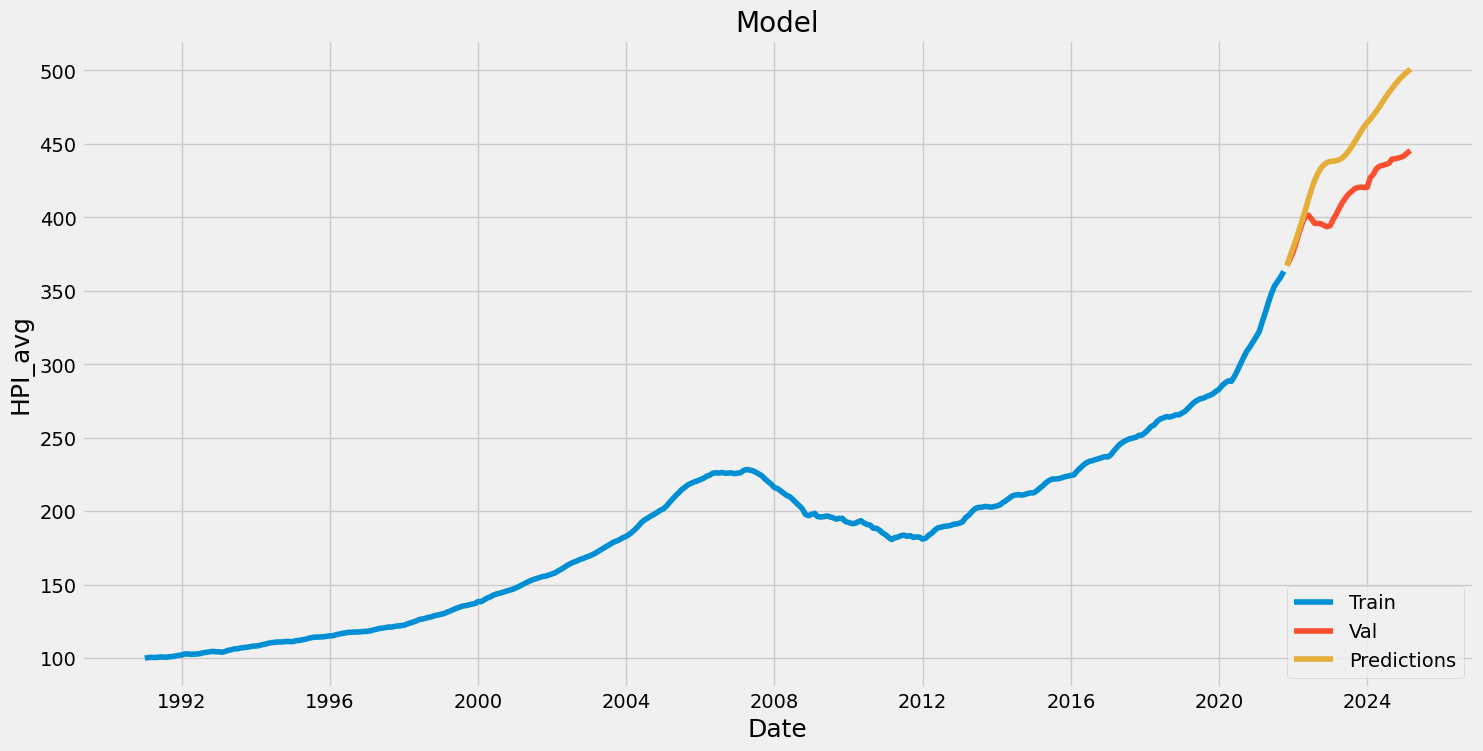

In [474]:
#Plot the data
train = Housing_prices_df[:Training_data_len]
valid = Housing_prices_df[Training_data_len:]
valid['Predictions'] = predictions
#visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('HPI_avg', fontsize=18)
plt.plot(train['avg_hpi'])
plt.plot(valid[['avg_hpi','Predictions']])
plt.legend(['Train','Val','Predictions'], loc = 'lower right')
plt.show()

In [475]:
#Show the valid and predicted prices
valid

,avg_hpi,Predictions
column1,,
2021-11-01,367.210999,367.115753
2021-12-01,371.511502,373.332367
2022-01-01,376.375504,379.395081
2022-02-01,383.091502,385.402039
2022-03-01,389.563000,391.604126
2022-04-01,395.991502,398.132141
2022-05-01,400.785500,405.050507
2022-06-01,401.434000,412.218628
2022-07-01,398.893498,419.119934


In [476]:
# Start with the last window of data (scaled)
last_sequence = scaled_data[-308:, 0]  # shape: (308,)
future_predictions = []

for _ in range(40):
    # Reshape for model: (1, 308, 1)
    input_seq = last_sequence.reshape(1, 308, 1)
    
    # Predict the next value
    next_pred_scaled = model.predict(input_seq)[0][0]
    future_predictions.append(next_pred_scaled)
    
    # Append new value and drop the oldest one to keep window size constant
    last_sequence = np.append(last_sequence[1:], next_pred_scaled)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

In [477]:
# Convert from scaled back to actual values
future_predictions_unscaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


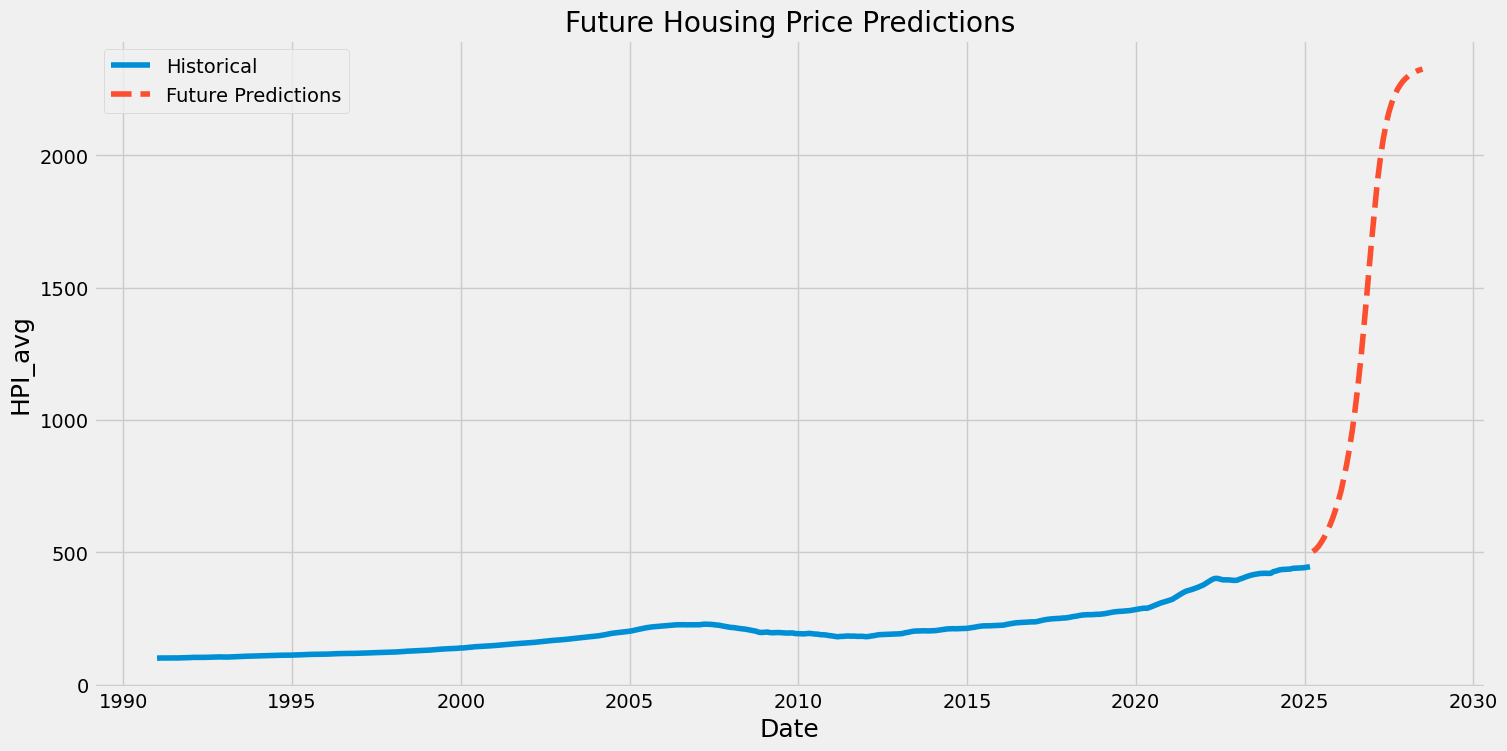

In [478]:
# Create date index for future months
last_date = Housing_prices_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=N, freq='MS')

# Build a DataFrame to store predictions
future_df = pd.DataFrame(data=future_predictions_unscaled, index=future_dates, columns=['Future_Predictions'])

# Plot historical + future
plt.figure(figsize=(16,8))
plt.title('Future Housing Price Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('HPI_avg', fontsize=18)

plt.plot(Housing_prices_df['avg_hpi'], label='Historical')
plt.plot(future_df['Future_Predictions'], label='Future Predictions', linestyle='--')
plt.legend()
plt.show()

In [479]:
import torch
print(torch.cuda.is_available())       # Should be True
print(torch.cuda.get_device_name(0))   # Should say your AMD GPU




True
AMD Radeon RX 9070 XT
